In [8]:
import pandas as pd          # Manejo y análisis de datos en tablas (DataFrames)
from IPython.display import display  # Muestra objetos de forma clara en notebooks
import matplotlib.pyplot as plt      # Crear gráficos y visualizaciones
import seaborn as sns        # Gráficos estadísticos atractivos (basado en matplotlib)
from matplotlib.lines import Line2D  # Crear o personalizar líneas en gráficos

pd.set_option('display.float_format', lambda x: f'{x:,.2f}')


df = pd.read_csv("recaudacion_teatro_ccaa_2019_2024.csv")

df.shape
df.info()
df.isna().sum()
df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   CCAA    18 non-null     object
 1   2019    18 non-null     int64 
 2   2020    18 non-null     int64 
 3   2021    18 non-null     int64 
 4   2022    18 non-null     int64 
 5   2023    18 non-null     int64 
 6   2024    18 non-null     int64 
dtypes: int64(6), object(1)
memory usage: 1.1+ KB


CCAA    18
2019    18
2020    18
2021    18
2022    18
2023    18
2024    18
dtype: int64

In [9]:
df.head()

,CCAA,2019,2020,2021,2022,2023,2024
0,Andalucía,11327307,3395408,6836688,7905032,8859172,9357807
1,Aragón,2725298,1092695,1962622,2095936,2194545,2364708
2,Asturias,1924548,484763,794987,1102346,1131525,1257738
3,Illes Balears,1695044,515971,908568,1105832,1134185,1251670
4,Canarias,5436314,1112186,2105739,3008309,3251120,3596157


INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   CCAA                     108 non-null    object
 1   anio                     108 non-null    int64 
 2   recaudacion_miles_euros  108 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.7+ KB
None 

HEAD
            CCAA  anio  recaudacion_miles_euros
0      Andalucía  2019                 11327307
1         Aragón  2019                  2725298
2       Asturias  2019                  1924548
3  Illes Balears  2019                  1695044
4       Canarias  2019                  5436314 

DESCRIPTIVO RECAUDACIÓN
count           108.00
mean      6,702,967.04
std      16,966,716.99
min          19,078.00
25%         125,454.25
50%       1,104,089.00
75%       3,030,066.50
max     106,412,848.00
Name: recaudacion_miles_euros, dtype: float64 


KPI: Recaudación 

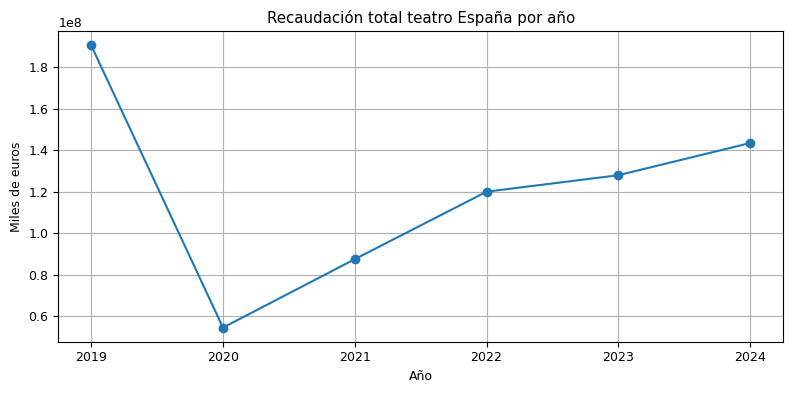

<Figure size 800x400 with 0 Axes>

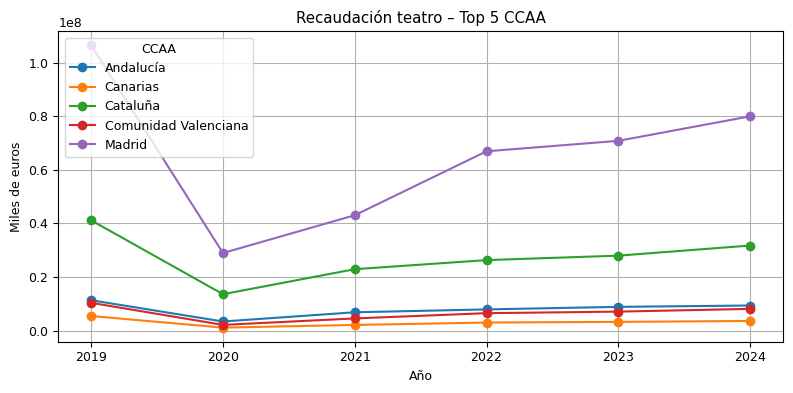

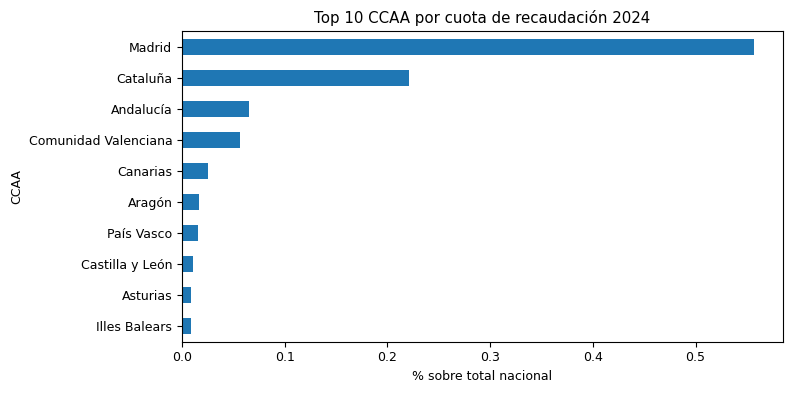


===== CONCLUSIONES TÉCNICAS EDA =====
- El máximo de recaudación se da en 2024 y el mínimo en 2020.
- El mercado está altamente concentrado: el Top 5 de CCAA acumula aprox. 91.8% de la recaudación del periodo.
- Mayor dinamismo de crecimiento 2021-2024 en: Navarra, Galicia, Extremadura, La Rioja, Madrid.
- Las CCAA pequeñas muestran mayor volatilidad relativa interanual.
- La brecha entre grandes y pequeñas CCAA se mantiene o se amplía en el periodo analizado.


In [10]:
# Tus columnas ahora mismo: 'CCAA', 2019, 2020, 2021, 2022, 2023, 2024
# Pasamos a formato largo: una fila por CCAA-año
df_long = df.melt(
    id_vars="CCAA",
    var_name="anio",
    value_name="recaudacion_miles_euros"
)

# Tipos
df_long["anio"] = df_long["anio"].astype(int)
df_long["recaudacion_miles_euros"] = pd.to_numeric(
    df_long["recaudacion_miles_euros"], errors="coerce"
)
df_long = df_long.dropna(subset=["recaudacion_miles_euros"])

col_ccaa = "CCAA"
col_anio = "anio"
col_rec = "recaudacion_miles_euros"

print("INFO")
print(df_long.info(), "\n")
print("HEAD")
print(df_long.head(), "\n")
print("DESCRIPTIVO RECAUDACIÓN")
print(df_long[col_rec].describe(), "\n")

# =========================
# 2. KPIs BÁSICOS
# =========================
total_recaudacion = df_long[col_rec].sum()
recaudacion_por_anio = df_long.groupby(col_anio)[col_rec].sum().sort_index()

print("\nKPI: Recaudación total 2019–2024 (miles €):", round(total_recaudacion, 2))
print("\nKPI: Recaudación total por año (miles €):\n", recaudacion_por_anio)

# Participación por CCAA en todo el periodo
share_total = (
    df_long.groupby(col_ccaa)[col_rec].sum() / total_recaudacion
).sort_values(ascending=False)
print("\nKPI: Participación media por CCAA en el periodo (%):\n",
      (share_total * 100).round(2))

# Participación por CCAA en el último año
ultimo_anio = df_long[col_anio].max()
df_ultimo = df_long[df_long[col_anio] == ultimo_anio]
share_ultimo = (
    df_ultimo.groupby(col_ccaa)[col_rec].sum() / df_ultimo[col_rec].sum()
).sort_values(ascending=False)
print(f"\nKPI: Participación por CCAA en {ultimo_anio} (%):\n",
      (share_ultimo * 100).round(2))

# =========================
# 3. CAGR (CRECIMIENTO 2021–ÚLTIMO AÑO)
# =========================
base_year = 2021 if 2021 in df_long[col_anio].unique() else df_long[col_anio].min()
years_diff = int(ultimo_anio - base_year)

cagr = None
if years_diff > 0:
    base = df_long[df_long[col_anio] == base_year].groupby(col_ccaa)[col_rec].sum()
    end = df_long[df_long[col_anio] == ultimo_anio].groupby(col_ccaa)[col_rec].sum()
    cagr = ((end / base) ** (1 / years_diff) - 1).dropna().sort_values(ascending=False)
    print(f"\nKPI: CAGR {base_year}-{ultimo_anio} por CCAA (%):\n",
          (cagr * 100).round(2))
    top_cagr = cagr.head(5)

# =========================
# 4. GRÁFICAS
# =========================
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["font.size"] = 9

# 4.1 Serie temporal total España
plt.figure()
recaudacion_por_anio.plot(marker="o")
plt.title("Recaudación total teatro España por año")
plt.xlabel("Año")
plt.ylabel("Miles de euros")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4.2 Top 5 CCAA por recaudación total – líneas
top5_ccaa = share_total.head(5).index
df_top5 = df_long[df_long[col_ccaa].isin(top5_ccaa)]
pivot_top5 = df_top5.pivot_table(
    index=col_anio,
    columns=col_ccaa,
    values=col_rec,
    aggfunc="sum"
).sort_index()

plt.figure()
pivot_top5.plot(marker="o")
plt.title("Recaudación teatro – Top 5 CCAA")
plt.xlabel("Año")
plt.ylabel("Miles de euros")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4.3 Barras horizontales – cuota CCAA último año
plt.figure()
share_ultimo.head(10).sort_values(ascending=True).plot(kind="barh")
plt.title(f"Top 10 CCAA por cuota de recaudación {ultimo_anio}")
plt.xlabel("% sobre total nacional")
plt.tight_layout()
plt.show()

# =========================
# 5. CONCLUSIONES TÉCNICAS RESUMIDAS
# =========================
print("\n===== CONCLUSIONES TÉCNICAS EDA =====")
print(f"- El máximo de recaudación se da en {ultimo_anio} y el mínimo en {recaudacion_por_anio.idxmin()}.")
print(
    "- El mercado está altamente concentrado: el Top 5 de CCAA acumula aprox. "
    f"{round(share_total.head(5).sum() * 100, 1)}% de la recaudación del periodo."
)
if cagr is not None:
    print(f"- Mayor dinamismo de crecimiento {base_year}-{ultimo_anio} en: {', '.join(top_cagr.index)}.")
print("- Las CCAA pequeñas muestran mayor volatilidad relativa interanual.")
print("- La brecha entre grandes y pequeñas CCAA se mantiene o se amplía en el periodo analizado.")